# **Pharma Drug Sales – Analysis and Forecasting**

## **Table of contents**

- [1. Introduction](#1-introduction)
- [2. Setup - Installing and loading packages](#2-setup---installing-and-loading-packages)
- [3. Data preparation](#3-data-preparation)
  - [3.1. Reading the data](#31-reading-the-data)
  - [3.2. Data preprocessing](#32-data-preprocessing)
- [4. Exploratory Data Analysis](#4-exploratory-data-analysis)
  - [4.1. Time series plot](#41-time-series-plot)
  - [4.2. Seasonal plots](#42-seasonal-plots)
  - [4.3. Variance stabilization](#43-variance-stabilization)
    - [4.3.1. Logarithmic transformation](#logarithmic-transformation)
    - [4.3.2. Best Box-Cox transformation](#best-box-cox-transformation)
  - [4.4. Seasonal-Trend decomposition using Loess (STL)](#44-seasonal-trend-decomposition-using-loess-stl)
  - [4.5. Autocorrelation and Partial Autocorrelation functions](#45-autocorrelation-and-partial-autocorrelation-functions)
    - [4.5.1. Original time series](#original-time-series)
    - [4.5.2. Log-Transformed time series](#log-transformed-time-series)
    - [4.5.3. Residuals](#residuals)
  - [4.6. Stationary tests](#46-stationary-tests)
    - [4.6.1. Augmented Dickey-Fuller (ADF) Test](#augmented-dickey-fuller-adf-test)
    - [4.6.2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test](#kwiatkowski-phillips-schmidt-shin-kpss-test)
- [5. Data partitioning](#5-data-partitioning)
- [6. Modelling](#6-modelling)
  - [6.1. Autoregressive models](#61-autoregressive-models)
    - [6.1.1. AR(2)](#ar2)
    - [6.1.2. AR(3)](#ar3)
  - [6.2. SARIMA models](#62-sarima-models)
    - [6.2.1. SARIMA(0,1,1)(1,1,1)[52]](#sarima01111152)
    - [6.2.2. SARIMA(1,1,1)(1,1,1)[52]](#sarima11111152)
  - [6.3. Alternative modelling using STL decomposition](#63-alternative-modelling-using-stl-decomposition)
    - [6.3.1. Trend modelling - Linear model](#trend-modelling---linear-model)
    - [6.3.2. Seasonality modelling - Fourier series](#seasonality-modelling---fourier-series)
    - [6.3.3. Residuals modelling - ARIMA(1,2,2)](#residuals-modelling---arima122)
  - [6.4. Choosing the best model](#)
- [7. Forecasting strategies](#7-forecasting-strategies)
  - [7.1. Forecasting 52 weeks ahead](#71-forecasting-52-weeks-ahead)
  - [7.2. Forecasting 52 weeks ahead with 1-step ahead - Interaction](#72-forecasting-52-weeks-with-1-step-ahead---interaction)
  - [7.3. Forecasting 52 weeks ahead with 1-step ahead - Expanding windows](#73-forecasting-52-weeks-with-1-step-ahead---expanding-windows)
  - [7.4. Forecasting 52 weeks ahead with 1-step ahead - Recursive windows](#74-forecasting-52-weeks-with-1-step-ahead---recursive-windows)
  - [7.5. Decomposition forecasting](#75-decomposition-forecasting)
    - [7.5.1. Decomposition forecasting 52 weeks ahead](#decomposition-forecasting-52-weeks-ahead)
    - [7.5.2. Decomposition forecasting 52 weeks ahead - Interaction](#decomposition-forecasting-52-weeks-with-1-step-ahead---interaction)
    - [7.5.3. Decomposition forecasting 52 weeks ahead - Expanding windows](#decomposition-forecasting-52-weeks-with-1-step-ahead---expanding-windows)
    - [7.5.4. Decomposition forecasting 52 weeks ahead - Recursive windows](#decomposition-forecasting-52-weeks-with-1-step-ahead---recursive-windows)
- [8. Assessing the quality of produced forecasts](#8-assessing-the-quality-of-produced-forecasts)
  - [8.1. Plotting the forecasts](#81-plotting-the-forecasts)
  - [8.2. Plotting the forecast residuals](#82-plotting-the-forecast-residuals)
  - [8.3. Accuracy measures](#83-accurary-measures)
- [Conclusions](#conclusions)
- [Bibliography](#bibliography)

## **1. Introduction**  

This project aims to analyze and forecast **pharmaceutical drug sales** using time series data over six years (2024–2019). The primary objective is to uncover underlying patterns in the data and build models capable of making accurate sales forecasts.

## **2. Setup - Installing and loading packages**

In [402]:
import warnings
warnings.filterwarnings('ignore')

The necessary packages — `statsmodels`, `pandas`, `scipy`, `matplotlib`, `numpy`, `seaborn`, `scikit-learn` — are installed as follows:

In [403]:
%pip install statsmodels pandas scipy matplotlib numpy seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


Once installed, the packages are loaded into the environment:

In [404]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.optimize import curve_fit

## **3. Data preparation**

### **3.1. Reading the data**

The chosen dataset for this study is derived from a Point-of-Sale (POS) system of a single pharmacy, covering a period of six years. The research underlying this project considers eight distinct time series, each summarizing the sales of a specific group of pharmaceutical products. These time series exhibit varying statistical features, offering a diverse foundation for analysis and forecasting.

In [405]:
drug_sales = pd.read_csv('salesweekly.csv')
drug_sales.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,1/5/2014,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0
1,1/12/2014,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2
2,1/19/2014,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0
3,1/26/2014,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0
4,2/2/2014,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0


### **3.2. Data preprocessing**

To facilitate data analysis, we will preprocess the data by:
 
**1.** Setting the `date` column as the index 

In [406]:
drug_sales.rename(columns={'datum': 'date'}, inplace=True)
drug_sales['date'] = pd.to_datetime(drug_sales['date'], format='%m/%d/%Y')
drug_sales.set_index('date', inplace=True)
drug_sales = drug_sales.asfreq('W-SUN')

**2.** Creating additional columns, `year` and `week`. These new columns will help track the specific week within each year, which is particularly useful for identifying and analyzing seasonal patterns.

In [407]:
drug_sales['Week'] = drug_sales.index.to_series().dt.isocalendar().week
drug_sales['Year'] = drug_sales.index.to_series().dt.isocalendar().year

## **4. Exploratory Data Analysis**

In this study, we will focus on the analysis of the **R06 category**, which includes **antihistamines for systemic use**. This category is particularly relevant due to its consistent demand and significance within the pharmaceutical sector, making it an ideal candidate for exploring time series patterns and building robust forecasting models.

In [408]:
R06 = drug_sales['R06']

### **4.1. Time series plot**

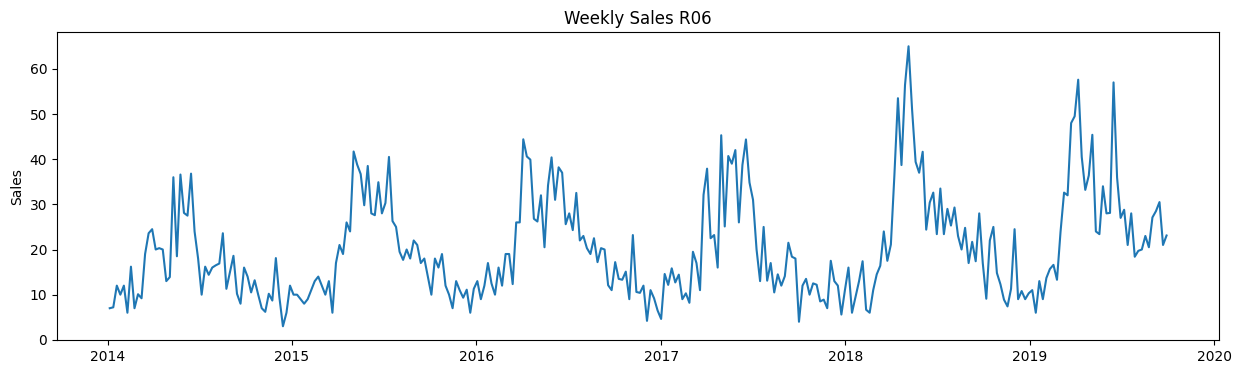

In [409]:
def plot_time_series(data, title, ylabel):
    plt.figure(figsize=(15, 4))
    plt.plot(data.index, data)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

plot_time_series(R06, 'Weekly Sales R06', 'Sales')

By visualizing the time series data, we observe the following:

- **1. Trend:** There is no clear evidence of a trend.

- **2. Seasonality:** The data exhibits pronounced seasonality.

- **3. Variance:** The variance remains relatively stable, with the exception of a noticeable spike during the early weeks of 2018.

### **4.2. Seasonal Plots**

For a clearer representation of the seasonal patterns, we may use the seasonal plots.

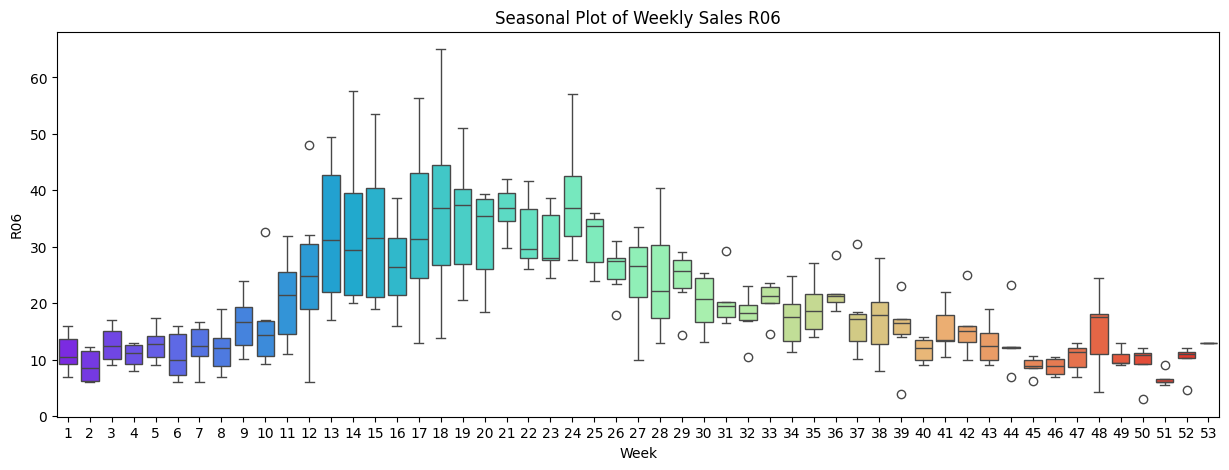

In [410]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=drug_sales, x='Week', y='R06', palette='rainbow')
plt.title('Seasonal Plot of Weekly Sales R06')
plt.show()

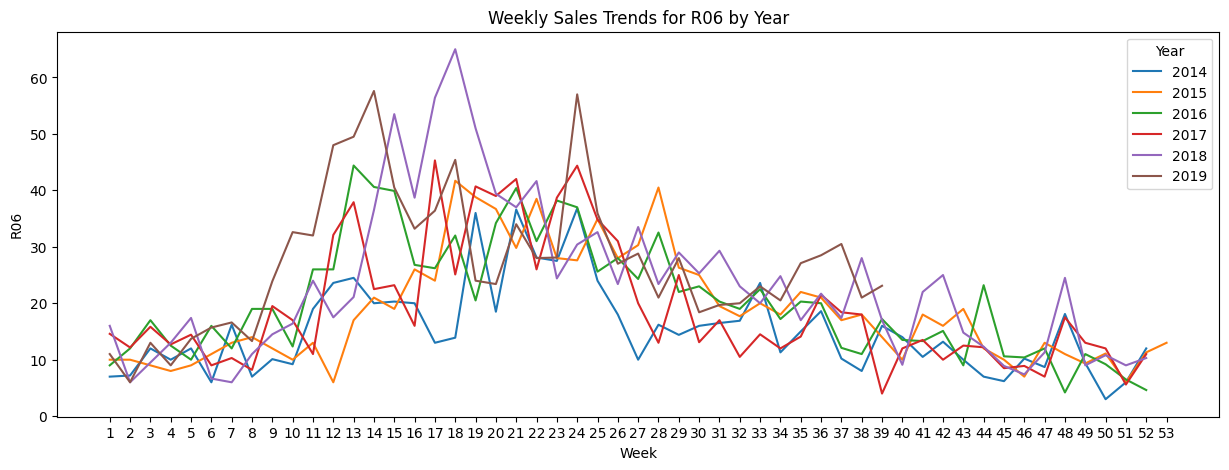

In [411]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=drug_sales, x="Week", y="R06", hue="Year", palette='tab10')
plt.title('Weekly Sales Trends for R06 by Year')
plt.legend(title="Year", loc='upper right')
plt.xticks(ticks=np.arange(1, 54, 1))
plt.show()

Looking at both seasonal plots, we observe that sales tend to peak during the spring, gradually declining throughout the rest of the year. This pattern aligns with expectations, given the nature of antihistamines and their increased demand during allergy seasons.

### **4.3. Variance stabilization**

#### **Logarithmic transformation**

To stabilize the variability over the series, the Box-Cox transformations can be applied. One specific case of this transformation is to take the **logarithm of the data**.

In [412]:
R06_log = np.log(R06)

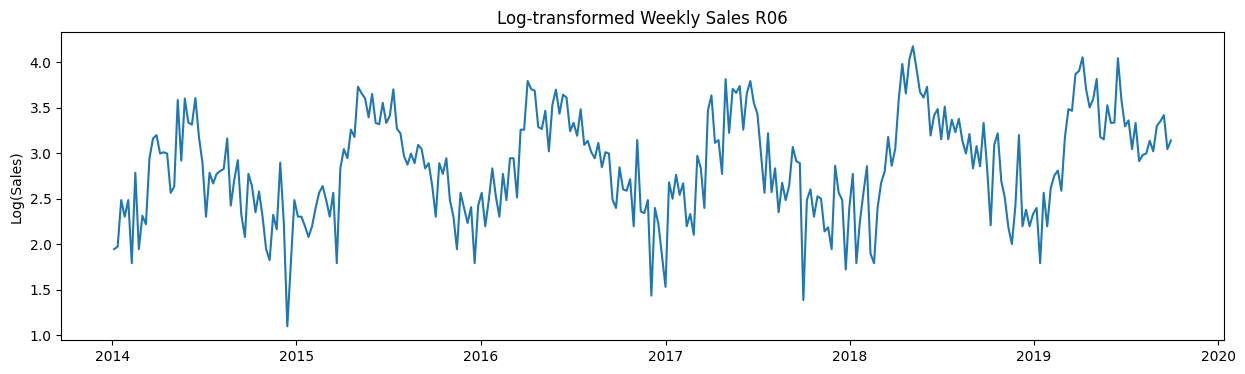

In [413]:
plot_time_series(R06_log, 'Log-transformed Weekly Sales R06', 'Log(Sales)')

The time series, after applying a **log transformation**, appears to exhibit reduced variance, as the spike observed in early 2018 is no longer noticeable.

#### **Best Box-Cox transformation**

To find the best **Box-Cox transform** - find lambda that minimizes the variance:


In [414]:
R06_boxcox, lambda_R06 = boxcox(R06)
lambda_R06

np.float64(0.10386437165796235)

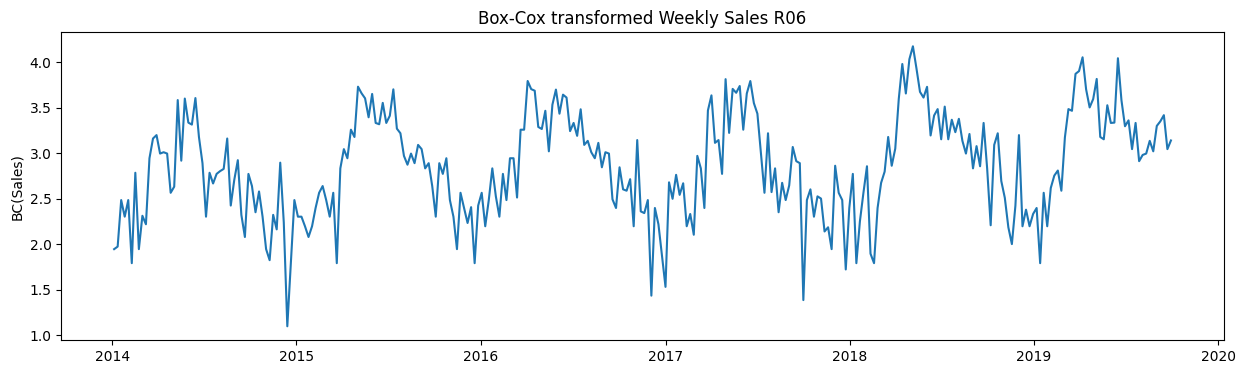

In [415]:
plot_time_series(R06_log, 'Box-Cox transformed Weekly Sales R06', 'BC(Sales)')

The Box-Cox transformed time series is highly similar to the log-transformed series, as the lambda value is close to 0. **To maintain simplicity and enhance interpretability, we will use the log-transformed time series in the following sections.**

### **4.4. Seasonal-Trend decomposition using Loess (STL)**

The **Seasonal Decomposition of Time Series by Loess** decomposes a time series into seasonal, trend and irregular components using Loess.

In [416]:
stl = STL(R06_log, seasonal=53)
R06_stl = stl.fit()

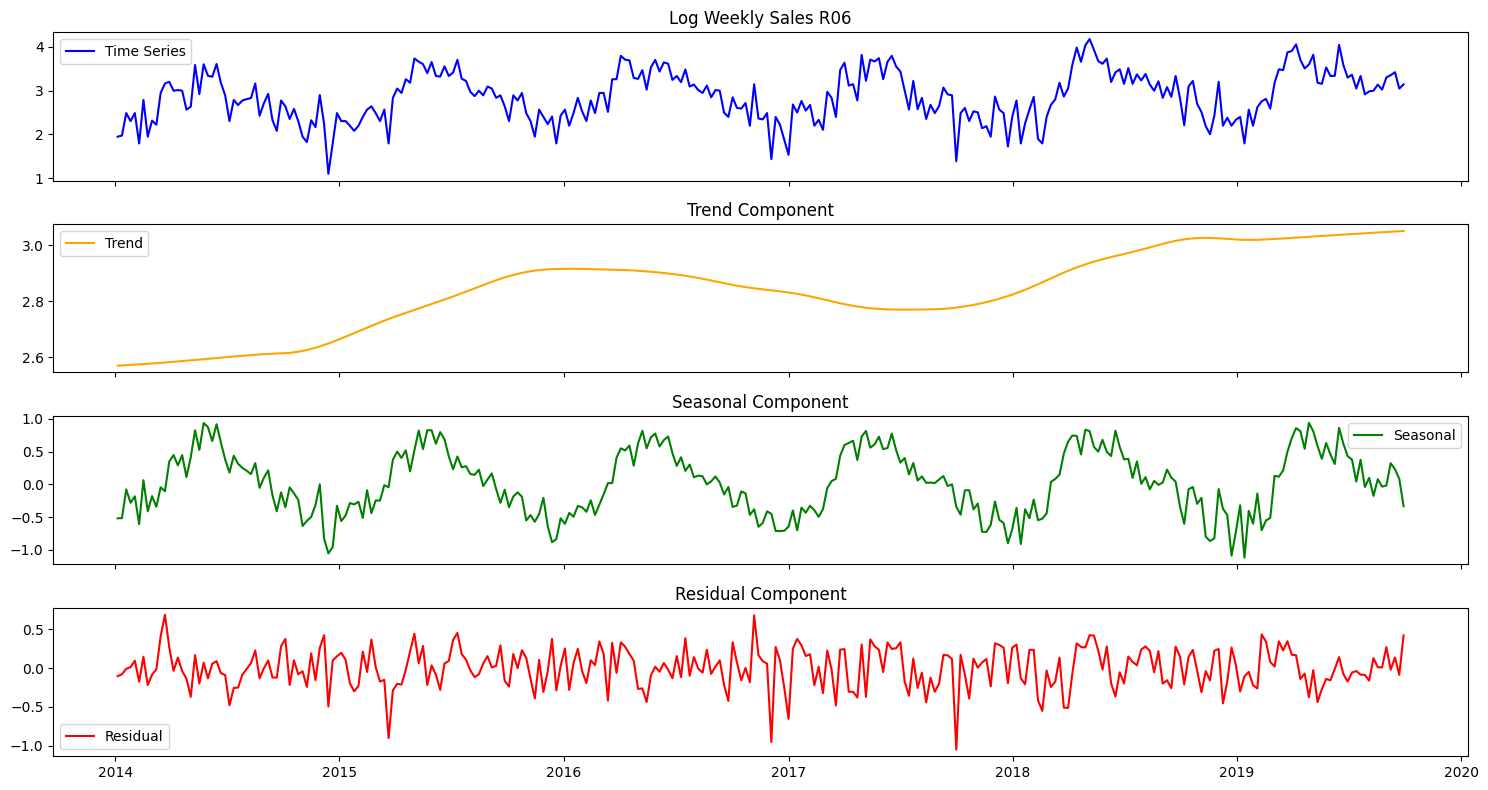

In [417]:
fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharex=True)

axes[0].plot(R06_log, label='Time Series', color='blue')
axes[0].set_title("Log Weekly Sales R06")
axes[0].legend()

# Trend component
axes[1].plot(R06_stl.trend, label='Trend', color='orange')
axes[1].set_title("Trend Component")
axes[1].legend()

# Seasonal component
axes[2].plot(R06_stl.seasonal, label='Seasonal', color='green')
axes[2].set_title("Seasonal Component")
axes[2].legend()

# Residual component
axes[3].plot(R06_stl.resid, label='Residual', color='red')
axes[3].set_title("Residual Component")
axes[3].legend()

plt.tight_layout()
plt.show()

From this decomposition, we can confirm some of the observations made earlier:

- **1. Lack of an evident trend:** The trend component does not show a clear directional movement over time.

- **2. Seasonality:** The seasonal component highlights a recurring pattern consistent with the previously observed seasonality.

### **4.5. Autocorrelation and Partial Autocorrelation Functions**

Autocorrelation and Partial Autocorrelation Functions provide valuable insights into the relationships within a time series:

- **1. Autocorrelation Function (ACF)**: Measures the correlation between the time series and its lagged values, capturing overall repeating patterns or dependencies at different time lags.

- **2. Partial Autocorrelation Function (PACF):** Focuses on the direct relationship between the time series and a specific lag, removing the influence of intermediate lags.

#### **Original time series**

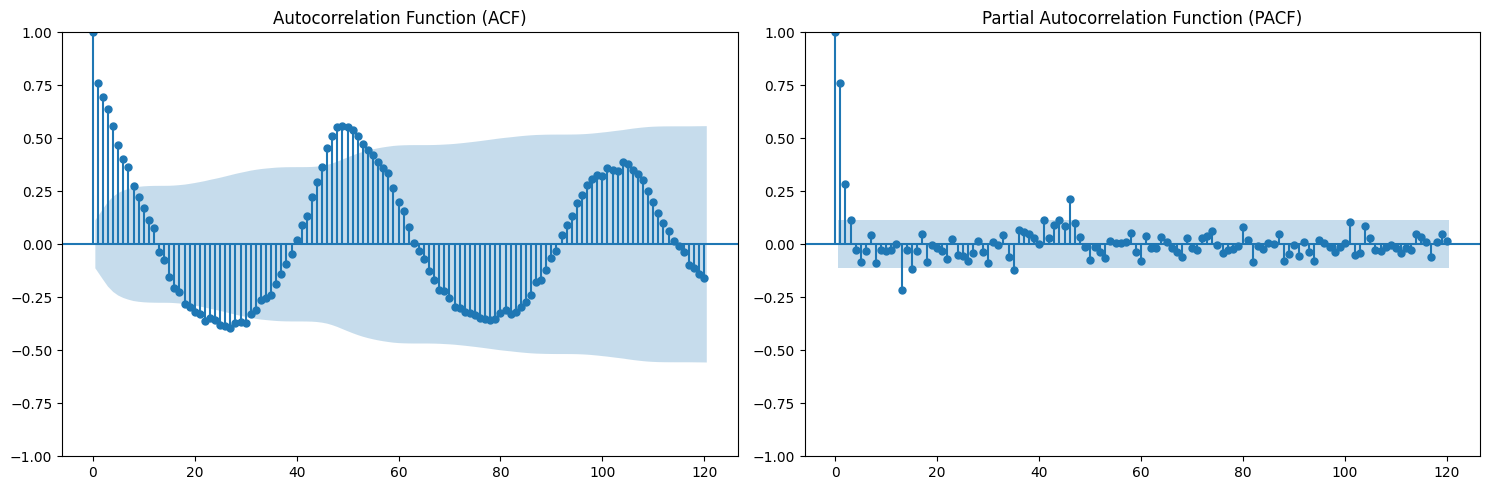

In [418]:
def plot_acf_pacf(data, num_lags=120):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    plot_acf(data, lags=num_lags, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')

    plot_pacf(data, lags=num_lags, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()

plot_acf_pacf(R06)

#### **Log-transformed time series**

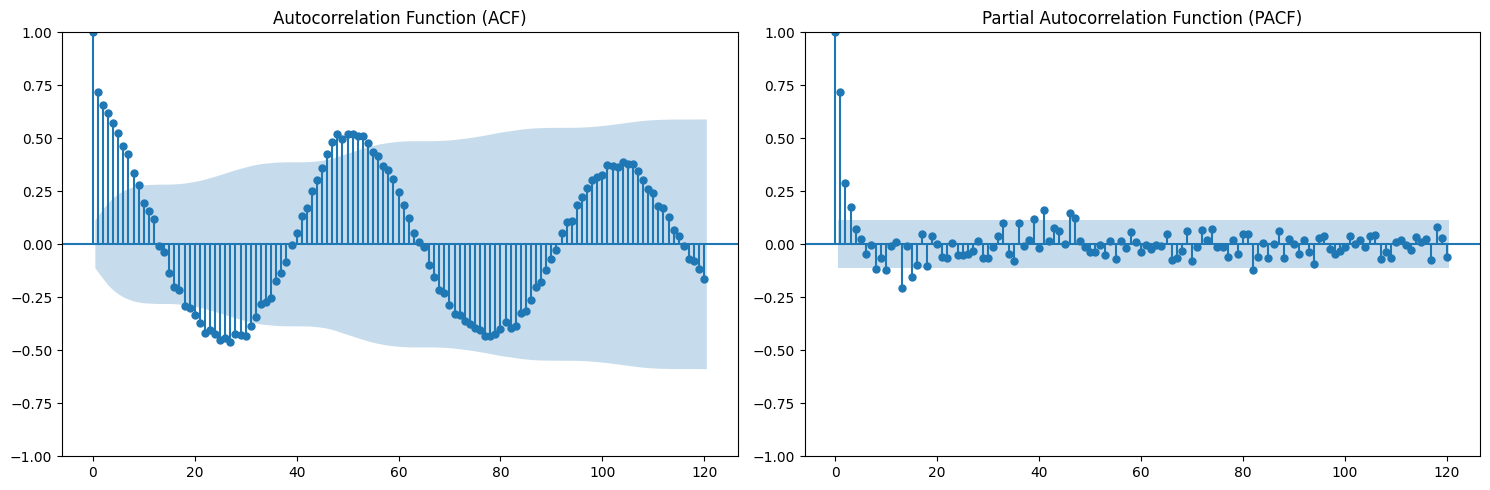

In [419]:
plot_acf_pacf(R06_log)

#### **Residuals**

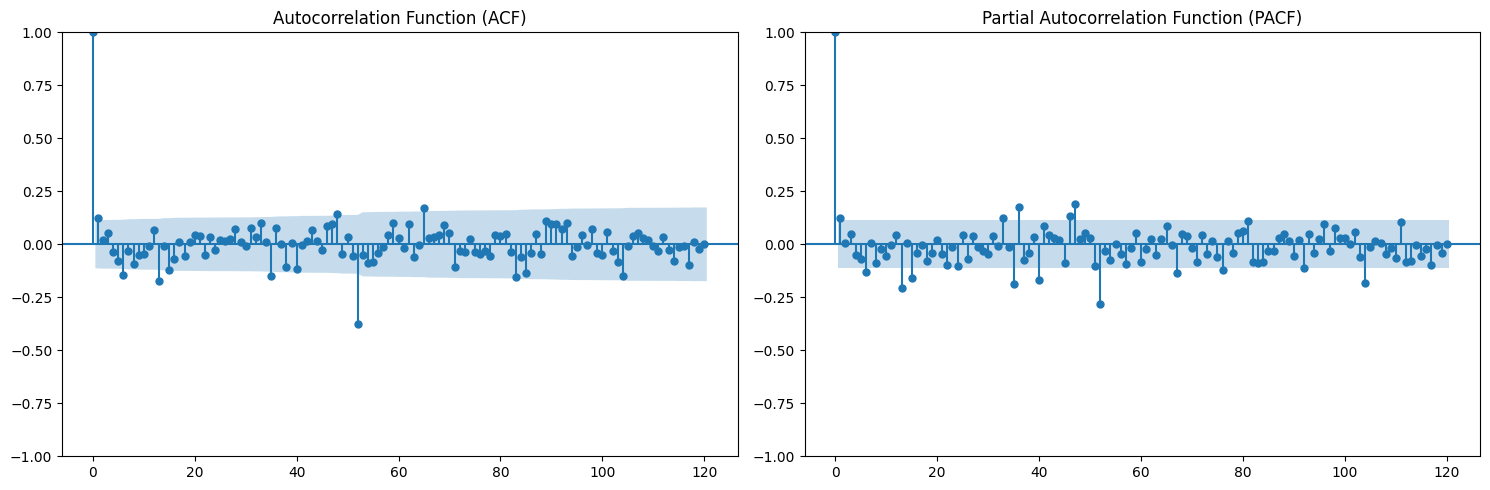

In [420]:
plot_acf_pacf(R06_stl.resid)

### **4.6. Stationary tests**


To assess the **stationarity of the time series**, the following two test methods were applied:

#### **Augmented Dickey-Fuller (ADF) Test**

**Null Hypothesis (H0)**: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

**Alternate Hypothesis (H1)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

In [421]:
def adf_test(data):
	p_value = 1
	num_diff = 0
	time_series = data.copy()
	while p_value > 0.05:
		adf_result, p_value, _, _, critical_values, _ = adfuller(time_series)

		if p_value <= 0.05:
			break

		time_series = time_series.diff().dropna()
		num_diff += 1
	
	print('Number of Differences: %d' % num_diff)
	print('ADF Statistic: %f' % adf_result)
	print('p-value: %f' % p_value)
	print('Critical Values:')
	for key, value in critical_values.items():
		print('\t%s: %.3f' % (key, value))
  
adf_test(R06_log)

Number of Differences: 0
ADF Statistic: -5.424644
p-value: 0.000003
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572


The ADF value is lower than the critical values (and p-value < 0.05) so the **log-transformed time series is stationary**.

#### **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test**

In [422]:
def kpss_test(data):
    num_diff = 0
    time_series = data.copy()
    
    while True:
        kpss_result, p_value, _, critical_values = kpss(time_series)
        
        if kpss_result >= critical_values['5%']:
            break
        
        time_series = time_series.diff().dropna()
        num_diff += 1
        
    print('Number of Differences: %d' % num_diff)
    print('KPSS Statistic: %f' % kpss_result)
    print('p-value: %f' % p_value)
    print('Critical Values:')
    for (key, value) in critical_values.items():
        print('\t%s: %.3f' % (key, value))
        
kpss_test(R06_log)

Number of Differences: 296
KPSS Statistic: 0.500000
p-value: 0.041667
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


The **KPSS test** indicates that 296 differences would be required to achieve a relatively stationary time series. However, applying such a high number of differences is impractical in real-world scenarios.

---

## **5. Data Partitioning**

The most recent **52 weeks** will be used as the testing set.

In [423]:
train = R06_log[:-52]
test = R06_log[-52:]
test_original = R06[-52:]

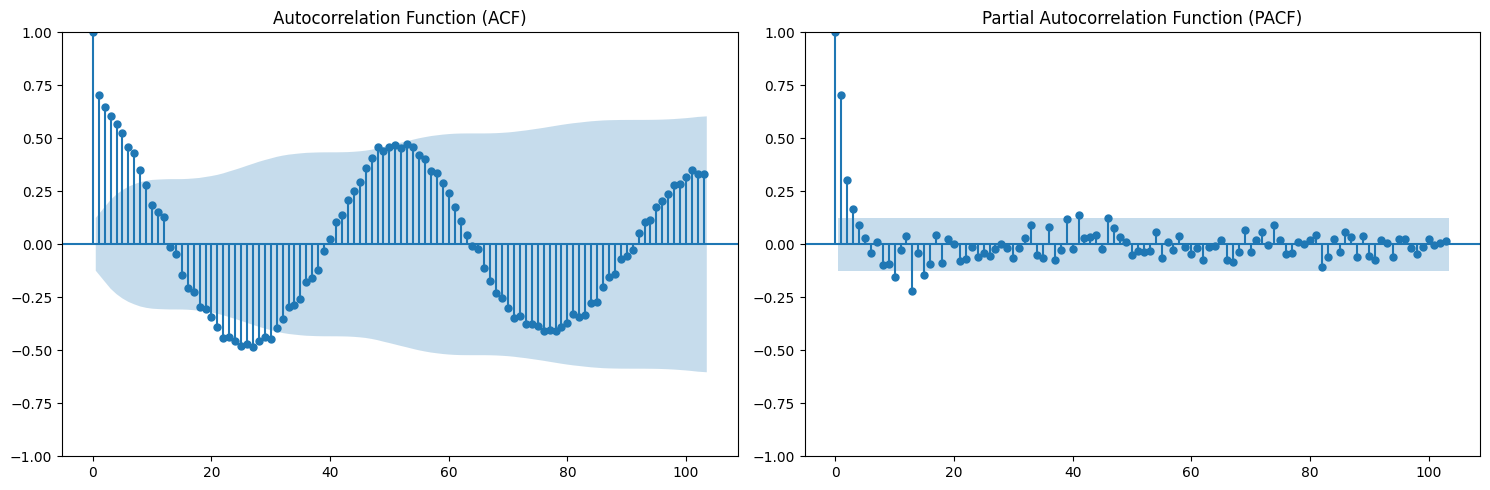

In [424]:
plot_acf_pacf(train, num_lags=103)

---

## **6. Modelling**

### **6.1. Autoregressive models**

By examining the ACF and PACF of the original time series, we observe that:

- the **ACF** clearly exhibits cyclic patterns and gradually approaches zero, indicating seasonality and diminishing correlations at higher lags.

- the **PACF** shows distinct spikes at lags 1, 2, and 3, suggesting strong direct correlations for these lags and their potential relevance in modeling autoregressive components.

Thus, we will consider two autoregressive models, AR(2) and AR(3), for further analysis.

#### **AR(2)**

In [425]:
ar2_model = SARIMAX(train, order=(2,0,0))
ar2_model_fit = ar2_model.fit()
ar2_ljung_box = acorr_ljungbox(ar2_model_fit.resid, lags=52, return_df=True)

In [426]:
ar2_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    R06   No. Observations:                  248
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -119.475
Date:                Thu, 09 Jan 2025   AIC                            244.950
Time:                        00:48:20   BIC                            255.490
Sample:                    01-05-2014   HQIC                           249.193
                         - 09-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5835      0.054     10.873      0.000       0.478       0.689
ar.L2          0.4093      0.053      7.713      0.000       0.305       0.513
sigma2         0.1509      0.011     13.443      0.000       0.129       0.173
===================================================================================
Ljung-Box (L1) (Q):                   2.28   Jarque-Bera (JB):                11.92
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -0.19
Prob(H) (two-sided):                  0.47   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

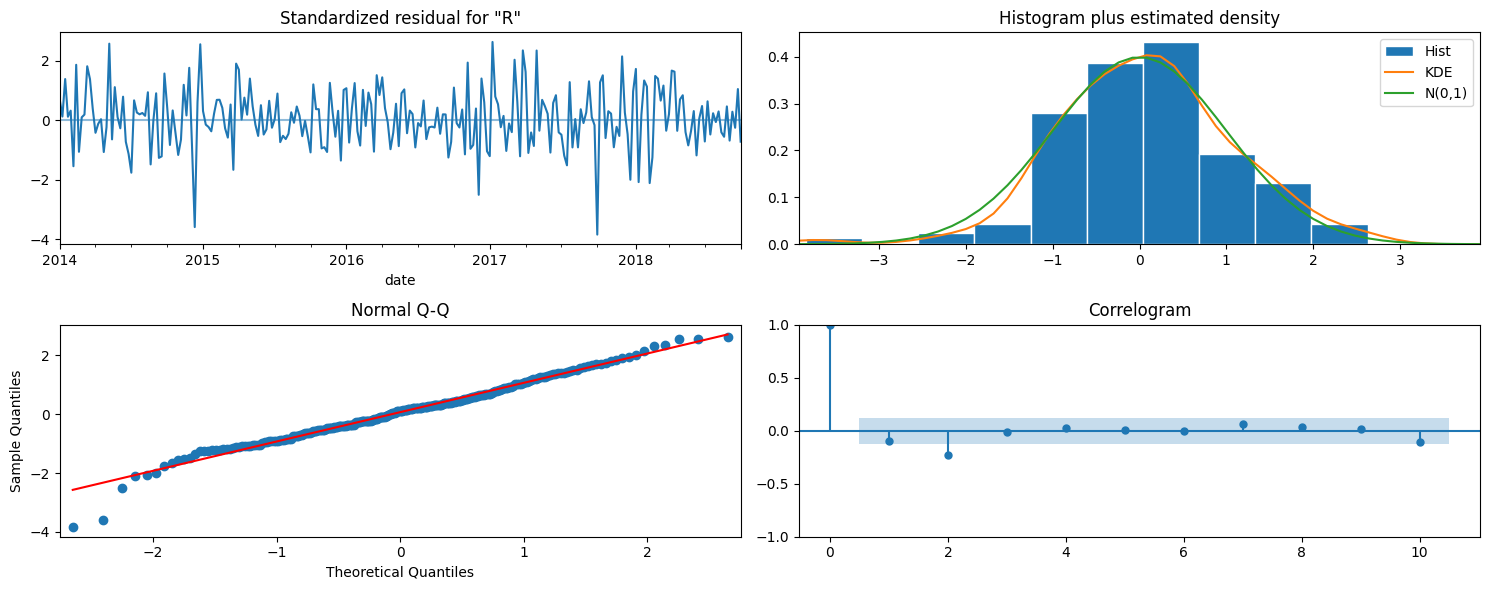

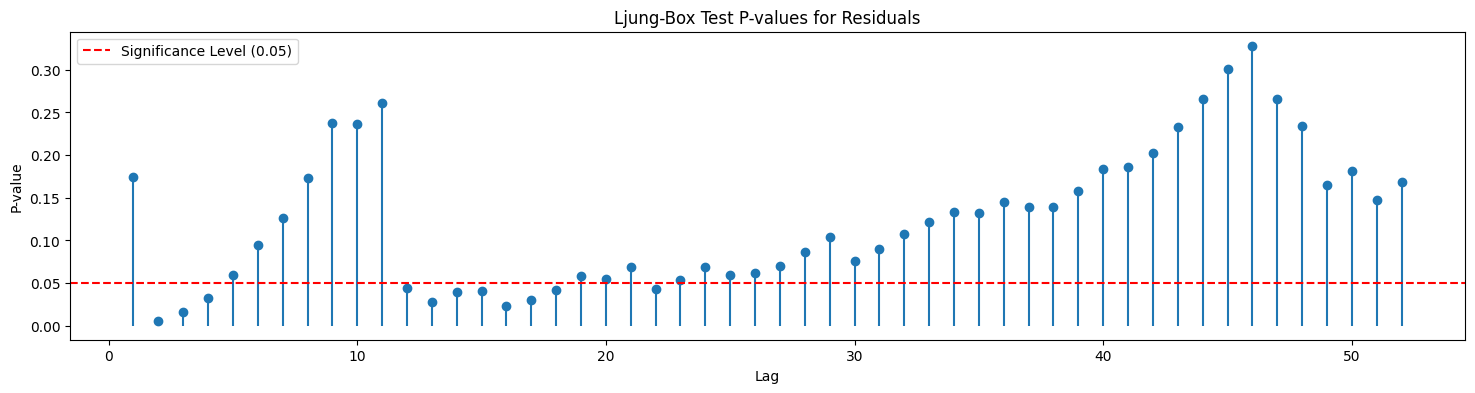

In [428]:
def plot_arima_diagnostics_and_ljungbox(model, ljung_box): 
    fig = plt.figure(figsize=(15, 6))
    model.plot_diagnostics(fig=fig)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(18, 4))
    plt.stem(ljung_box.index, ljung_box['lb_pvalue'], basefmt=" ")
    plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
    plt.title('Ljung-Box Test P-values for Residuals')
    plt.xlabel('Lag')
    plt.ylabel('P-value')
    plt.legend()
    plt.show()
    
plot_arima_diagnostics_and_ljungbox(ar2_model_fit, ar2_ljung_box)

For the AR(2) model, all the **parameters are statistically significant**; however, there is still **some correlation between the residuals**. This indicates that the model is insufficient to fully explain the data.

#### **AR(3)**

In [429]:
ar3_model = SARIMAX(train, order=(3,0,0))
ar3_model_fit = ar3_model.fit()
ar3_ljung_box = acorr_ljungbox(ar3_model_fit.resid, lags=52, return_df=True)

In [430]:
ar3_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    R06   No. Observations:                  248
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -113.195
Date:                Thu, 09 Jan 2025   AIC                            234.389
Time:                        01:09:39   BIC                            248.443
Sample:                    01-05-2014   HQIC                           240.047
                         - 09-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4924      0.062      7.960      0.000       0.371       0.614
ar.L2          0.2785      0.064      4.331      0.000       0.152       0.405
ar.L3          0.2233      0.063      3.571      0.000       0.101       0.346
sigma2         0.1434      0.011     13.471      0.000       0.123       0.164
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                14.82
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                            -0.28
Prob(H) (two-sided):                  0.54   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

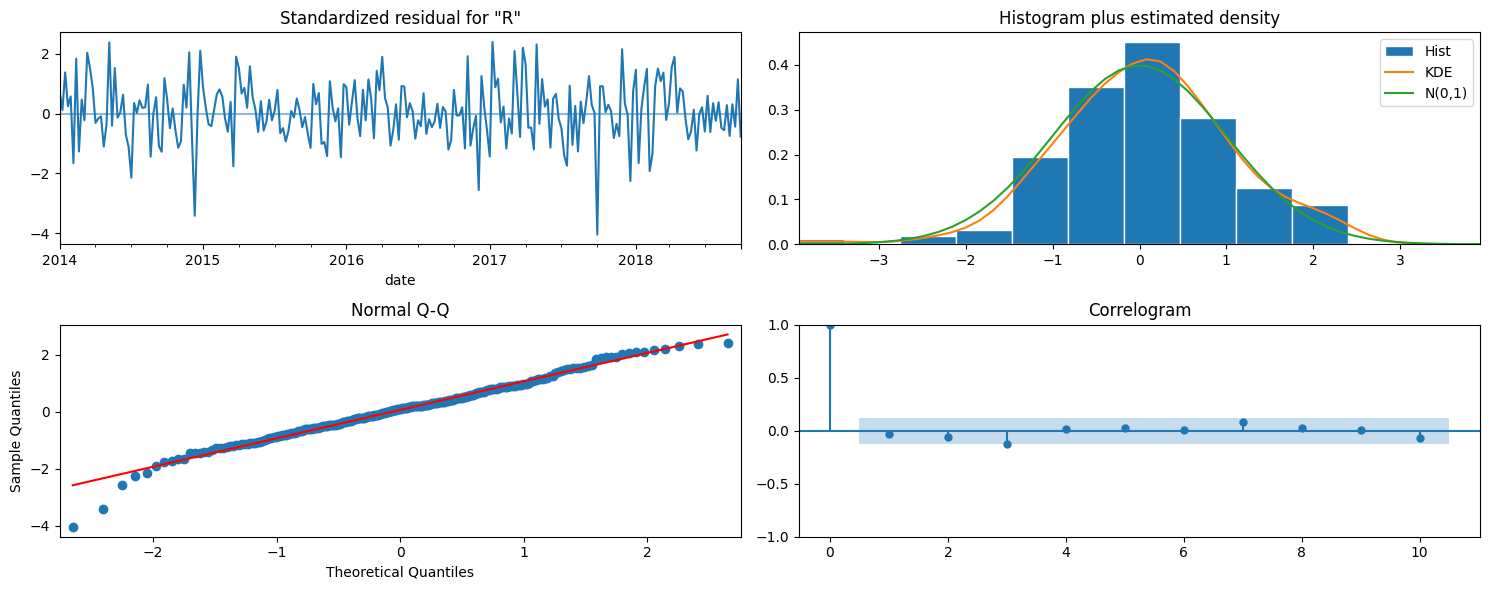

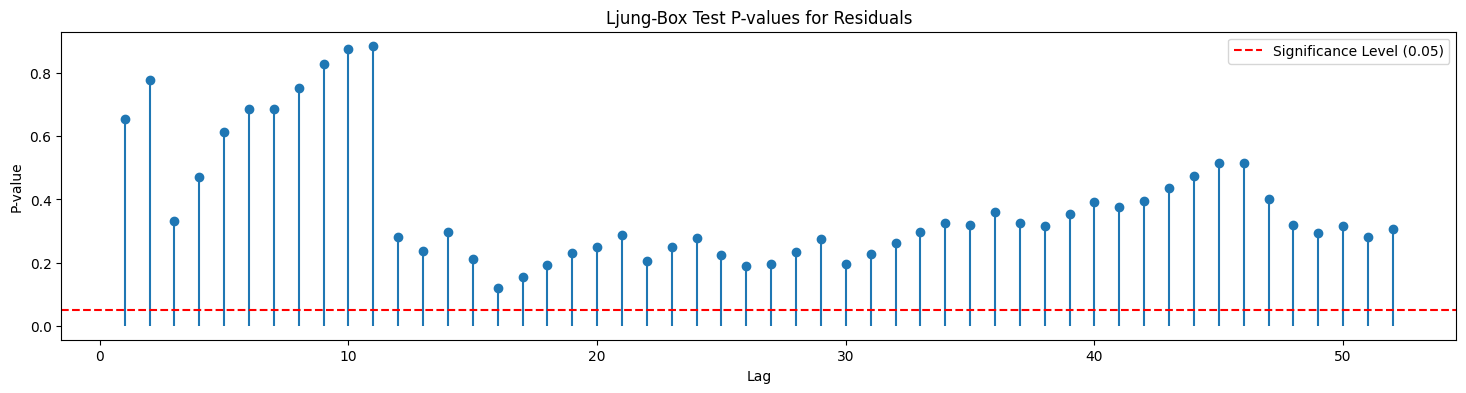

In [431]:
plot_arima_diagnostics_and_ljungbox(ar3_model_fit, ar3_ljung_box)

Using the AR(3) model, we observe that **all the parameters remain statistically significant**, and the **residuals are now independent**. This suggests that the AR(3) model provides a better fit to the data compared to the AR(2) model.

### **6.2. SARIMA models**

o address the seasonality, we have decided to apply a **52-step difference** to the time series, which corresponds to the seasonal cycle observed over the course of a year.

In [432]:
R06_seasonal_diff = R06_log.diff(52).dropna()

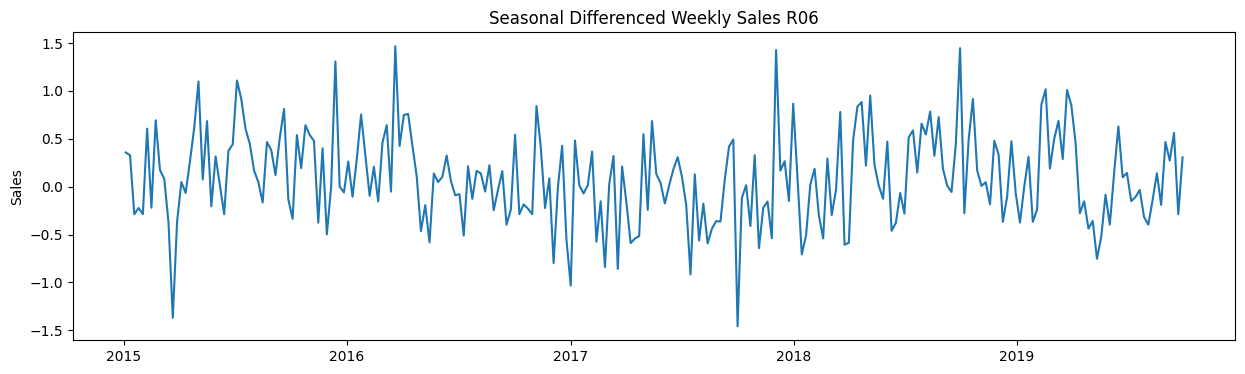

In [433]:
plot_time_series(R06_seasonal_diff, 'Seasonal Differenced Weekly Sales R06', 'Sales')

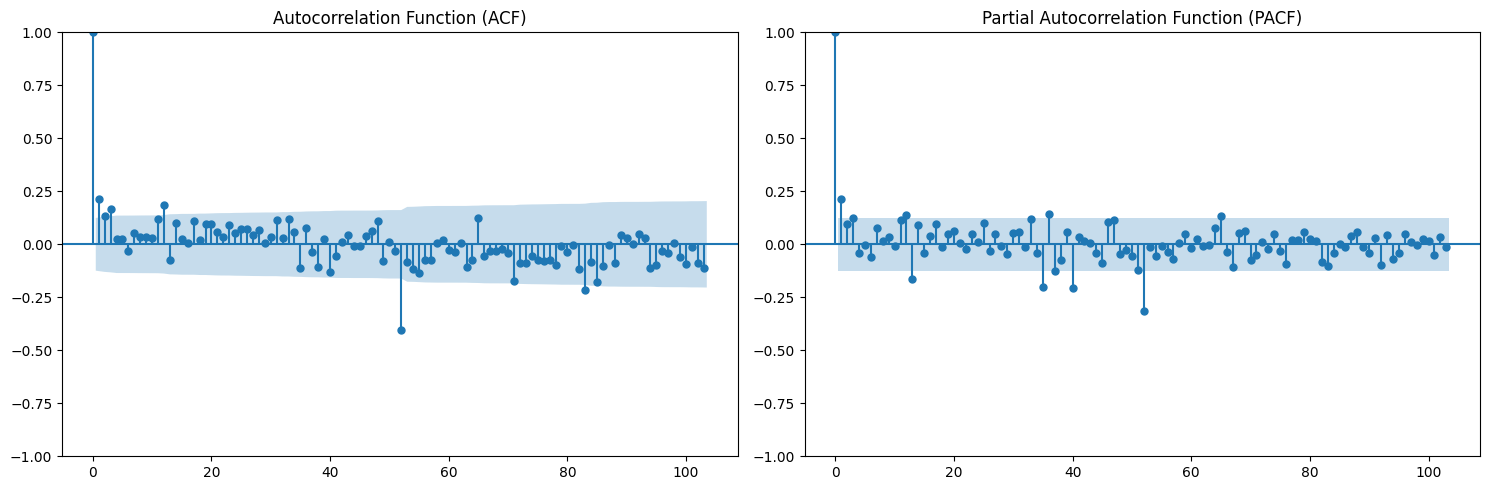

In [434]:
plot_acf_pacf(R06_seasonal_diff, 103)

**Augmented Dickey-Fuller (ADF) Test**

In [435]:
R06_seasonal_diff1 = R06_seasonal_diff.diff(1).dropna()
adf_test(R06_seasonal_diff1)

Number of Differences: 0
ADF Statistic: -7.109573
p-value: 0.000000
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573


Using the ADF test, we conclude that one difference (d=1) is enough to achieve stationarity in the time series.

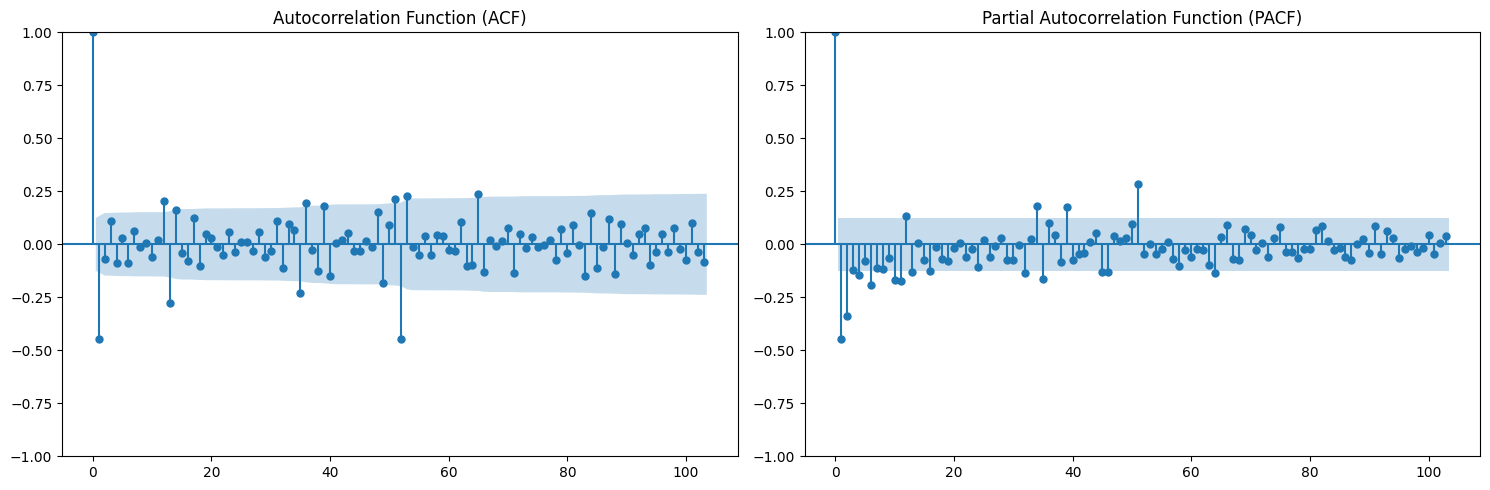

In [436]:
plot_acf_pacf(R06_seasonal_diff1, 103)

Looking at the ACF and PACF, we observe clear spikes at both **lag 1 and lag 52** in the plots. This suggests strong correlations at these specific lags, which likely correspond to immediate and seasonal dependencies in the time series.

#### **SARIMA(0,1,1)(1,1,1)\[52]**

In [437]:
sarima_p0_model = SARIMAX(train, order=(0,1,1), seasonal_order=(1,1,1,52))
sarima_p0_model_fit = sarima_p0_model.fit()
sarima_ljung_box = acorr_ljungbox(sarima_p0_model_fit.resid, lags=52, return_df=True)

In [438]:
sarima_p0_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                R06   No. Observations:                  248
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -105.063
Date:                            Thu, 09 Jan 2025   AIC                            218.127
Time:                                    01:15:19   BIC                            231.219
Sample:                                01-05-2014   HQIC                           223.427
                                     - 09-30-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9254      0.032    -29.144      0.000      -0.988      -0.863
ar.S.L52      -0.3075      0.164     -1.873      0.061      -0.629       0.014
ma.S.L52      -0.4197      0.195     -2.151      0.032      -0.802      -0.037
sigma2         0.1476      0.016      9.017      0.000       0.116       0.180
===================================================================================
Ljung-Box (L1) (Q):                   2.32   Jarque-Bera (JB):                 0.97
Prob(Q):                              0.13   Prob(JB):                         0.61
Heteroskedasticity (H):               1.32   Skew:                            -0.17
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

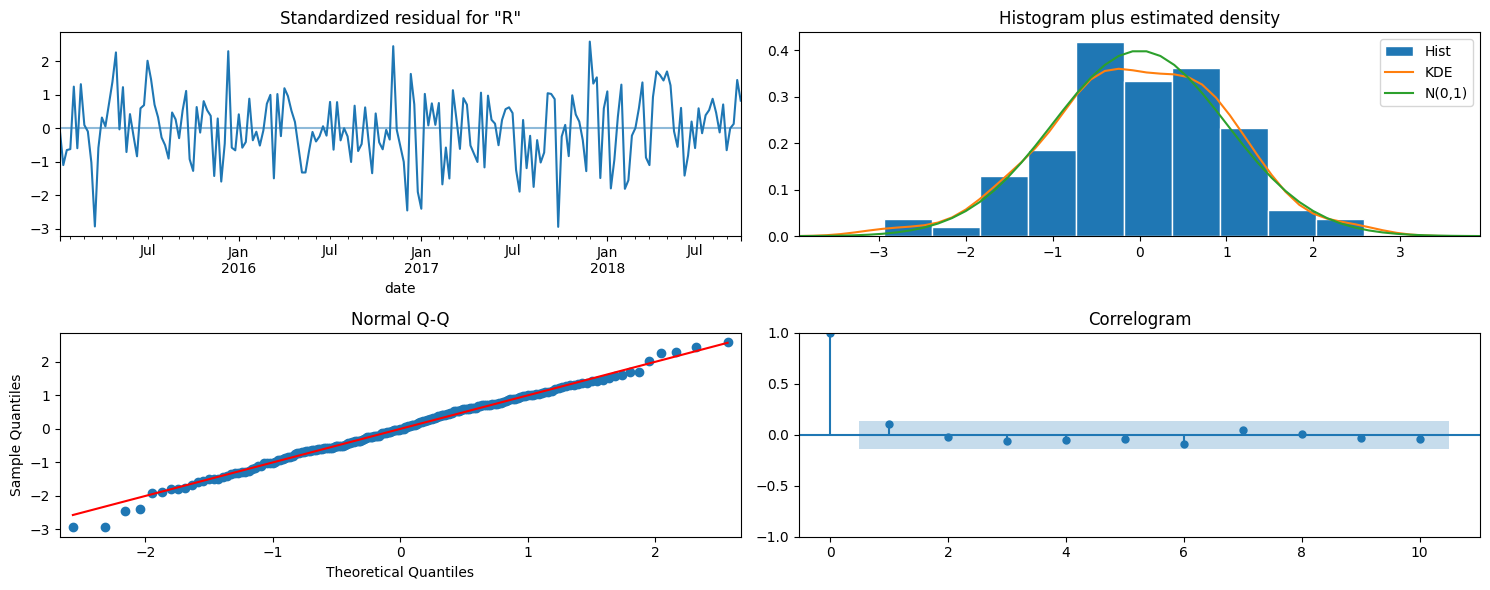

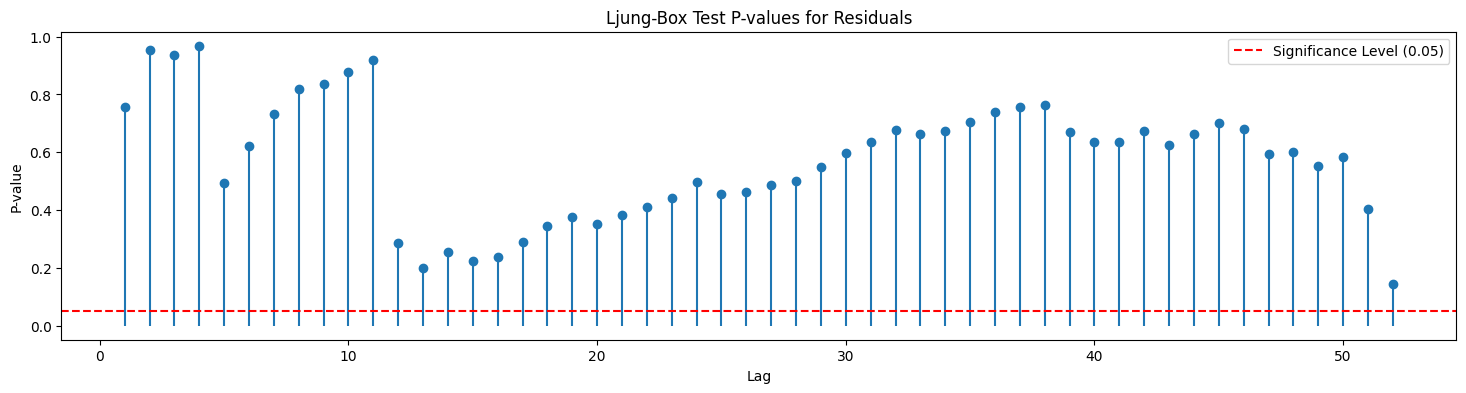

In [439]:
plot_arima_diagnostics_and_ljungbox(sarima_p0_model_fit, sarima_ljung_box)

In this SARIMA model, a**ll the parameters are statistically significant, and the residuals are uncorrelated**, indicating a good fit. Let's now check the model with p=1 to see if it further improves the performance.

#### **SARIMA(1,1,1)(1,1,1)\[52]**

In [440]:
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,52))
sarima_model_fit = sarima_model.fit()
sarima_ljung_box = acorr_ljungbox(sarima_model_fit.resid, lags=52, return_df=True)

In [441]:
sarima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                R06   No. Observations:                  248
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -103.633
Date:                            Thu, 09 Jan 2025   AIC                            217.266
Time:                                    01:17:11   BIC                            233.631
Sample:                                01-05-2014   HQIC                           223.892
                                     - 09-30-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1293      0.080      1.614      0.107      -0.028       0.286
ma.L1         -0.9395      0.033    -28.157      0.000      -1.005      -0.874
ar.S.L52      -0.3455      0.164     -2.101      0.036      -0.668      -0.023
ma.S.L52      -0.3694      0.202     -1.830      0.067      -0.765       0.026
sigma2         0.1463      0.016      9.196      0.000       0.115       0.178
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.02
Prob(Q):                              0.98   Prob(JB):                         0.60
Heteroskedasticity (H):               1.30   Skew:                            -0.17
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

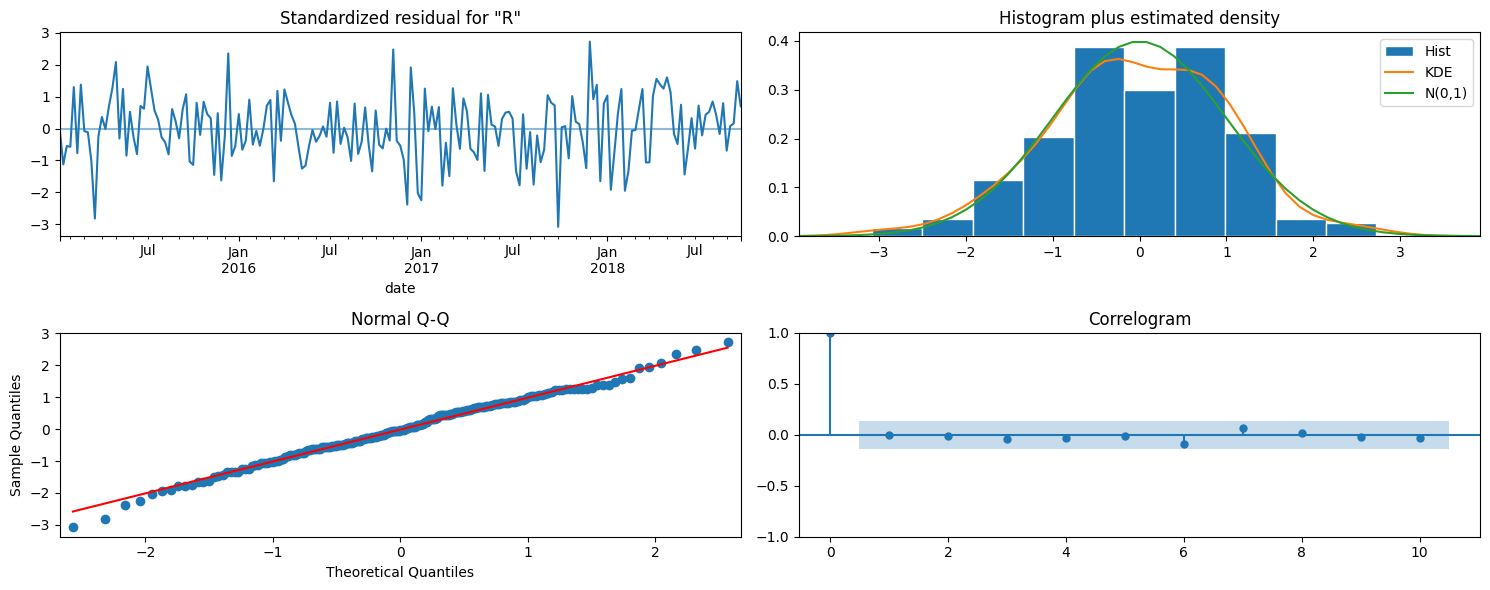

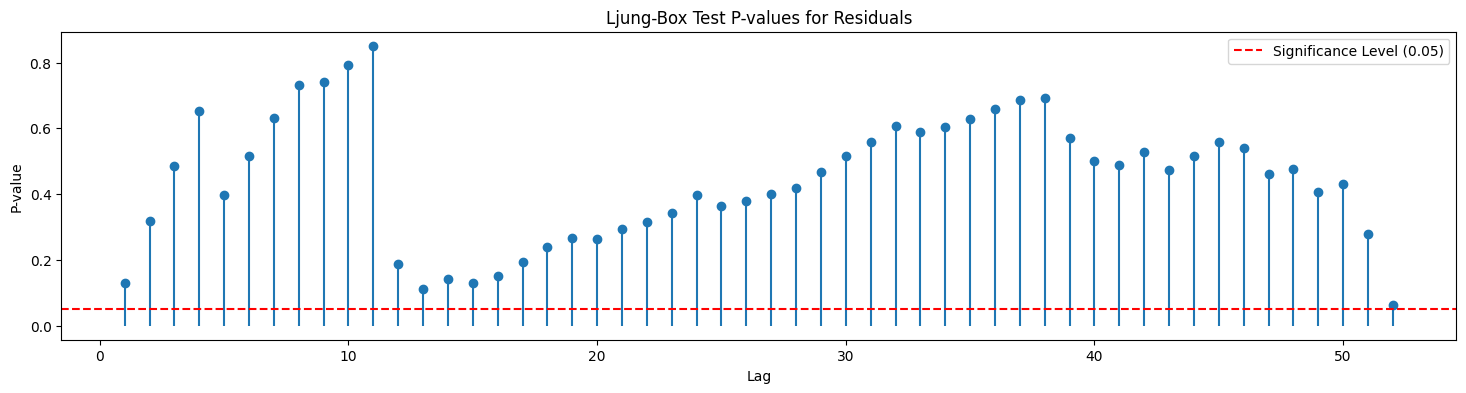

In [442]:
plot_arima_diagnostics_and_ljungbox(sarima_model_fit, sarima_ljung_box)

In this model, both requirements are also fulfilled, with **all parameters being statistically significant and the residuals uncorrelated**, making it a strong candidate for forecasting.

### **6.3. Alternative modelling using STL decomposition**

Using the STL decomposition we can create a **linear model** for the *Trend*, a **Fourier series** for the *Seasonal component* and use an **ARIMA model** to predict the *Residuals*.


#### **STL of the training data**

In [443]:
stl_train = STL(train, seasonal=53)  
stl_train_result = stl_train.fit()

#### **Trend modelling - Linear model**

In [444]:
x = np.arange(len(stl_train_result.trend)).reshape(-1, 1)
y = stl_train_result.trend.values

trend_model = LinearRegression()
trend_model.fit(x, y)

# Generate the trend line
trend_fit = trend_model.predict(x)

# transform the trend_fit into a pandas series
trend_fit = pd.Series(trend_fit, index=stl_train_result.trend.index)

#### **Seasonality modelling - Fourier series**

In [445]:
def fourier_series(x, a0, a1, b1, a2, b2):
    return a0 + a1 * np.cos(2 * np.pi * x / period) + b1 * np.sin(2 * np.pi * x / period) + \
           a2 * np.cos(4 * np.pi * x / period) + b2 * np.sin(4 * np.pi * x / period)

# Using seasonality of 52 weeks
period = 52
x = np.arange(len(stl_train_result.seasonal))
y = stl_train_result.seasonal.values

# Fit the Fourier series
params, _ = curve_fit(fourier_series, x, y)

# Generate the approximation
seasonal_fit = fourier_series(x, *params)

# Transform the seasonal_fit into a pandas series
seasonal_fit = pd.Series(seasonal_fit, index=stl_train_result.seasonal.index)

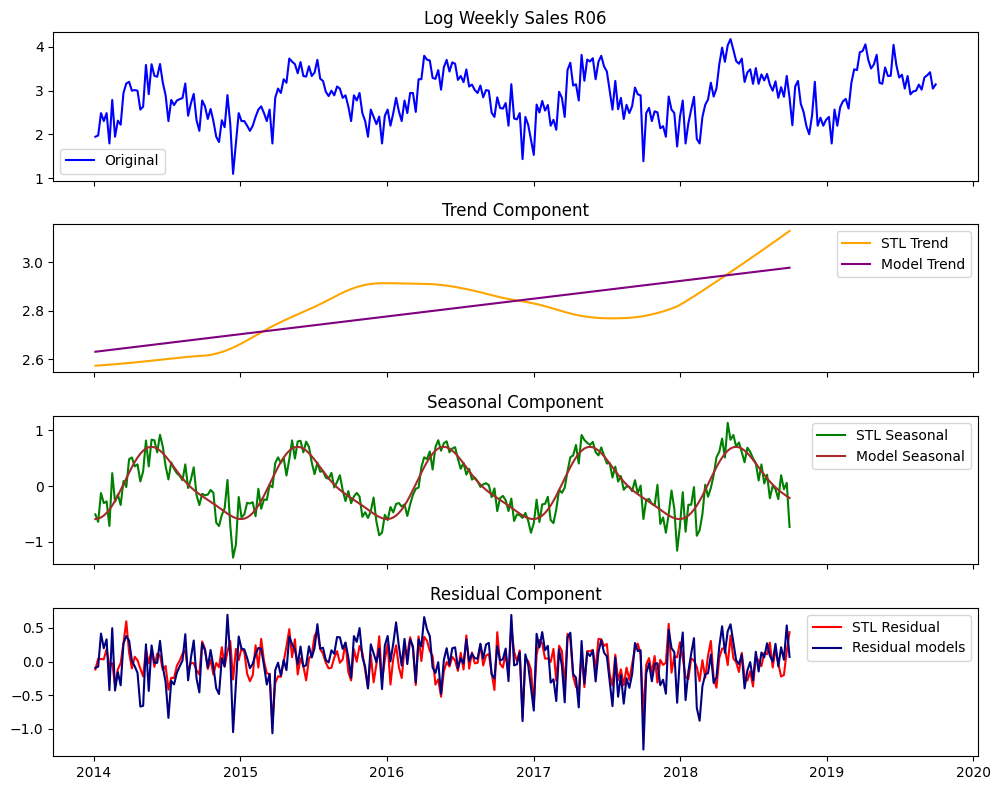

In [446]:
train_resid = train - trend_fit - seasonal_fit

# Plot the components
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Original time series
axes[0].plot(R06_log, label='Original', color='blue')
axes[0].set_title("Log Weekly Sales R06")
axes[0].legend()

# Trend component
axes[1].plot(stl_train_result.trend, label='STL Trend', color='orange')
axes[1].plot(trend_fit, label='Model Trend', color='purple')
axes[1].set_title("Trend Component")
axes[1].legend()

# Seasonal component
axes[2].plot(stl_train_result.seasonal, label='STL Seasonal', color='green')
axes[2].plot(seasonal_fit, label='Model Seasonal', color='brown')
axes[2].set_title("Seasonal Component")
axes[2].legend()

# Residual component
axes[3].plot(stl_train_result.resid, label='STL Residual', color='red')
axes[3].plot(train_resid, label='Residual models', color='navy')
axes[3].set_title("Residual Component")
axes[3].legend()

# Adjust layout
plt.tight_layout()
plt.show()

#### **Residuals modelling - ARIMA(1,2,2)**

Number of Differences: 0
ADF Statistic: -8.449695
p-value: 0.000000
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


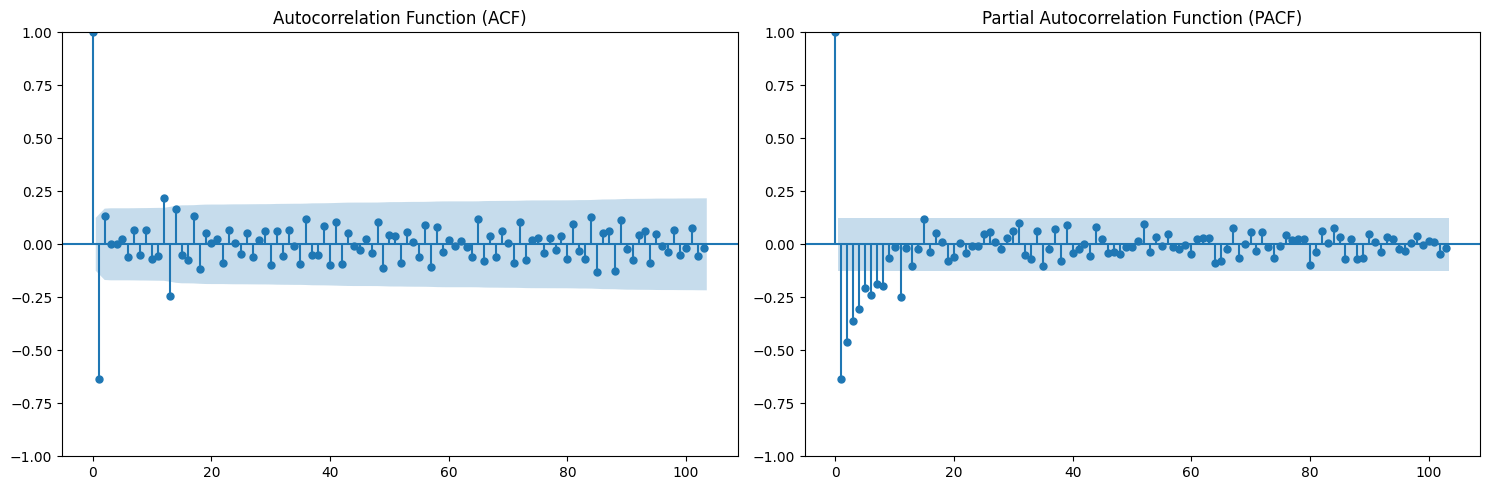

In [447]:
train_resid_diff2 = train_resid.diff(1).diff(1).dropna()

adf_test(train_resid_diff2)

plot_acf_pacf(train_resid_diff2, 103)

The residuals ACF shows a clear spike at lag 1, while the PACF gradually tends to 0. This suggests that there may still be some autocorrelation at lag 1, indicating that the current model might not fully capture the data's structure. Therefore, we will try the ARIMA(1,2,2) model to further refine the fit.

In [448]:
residual_model = SARIMAX(train_resid, order=(1,2,2))
residual_model_fit = residual_model.fit()
residual_ljung_box = acorr_ljungbox(residual_model_fit.resid, lags=52, return_df=True)

In [449]:
residual_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  248
Model:               SARIMAX(1, 2, 2)   Log Likelihood                 -76.820
Date:                Thu, 09 Jan 2025   AIC                            161.640
Time:                        01:19:40   BIC                            175.661
Sample:                    01-05-2014   HQIC                           167.286
                         - 09-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1427      0.068      2.094      0.036       0.009       0.276
ma.L1         -1.9789      0.027    -73.248      0.000      -2.032      -1.926
ma.L2          0.9838      0.027     36.255      0.000       0.931       1.037
sigma2         0.1043      0.008     12.622      0.000       0.088       0.121
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                18.75
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.51
Prob(H) (two-sided):                  0.64   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

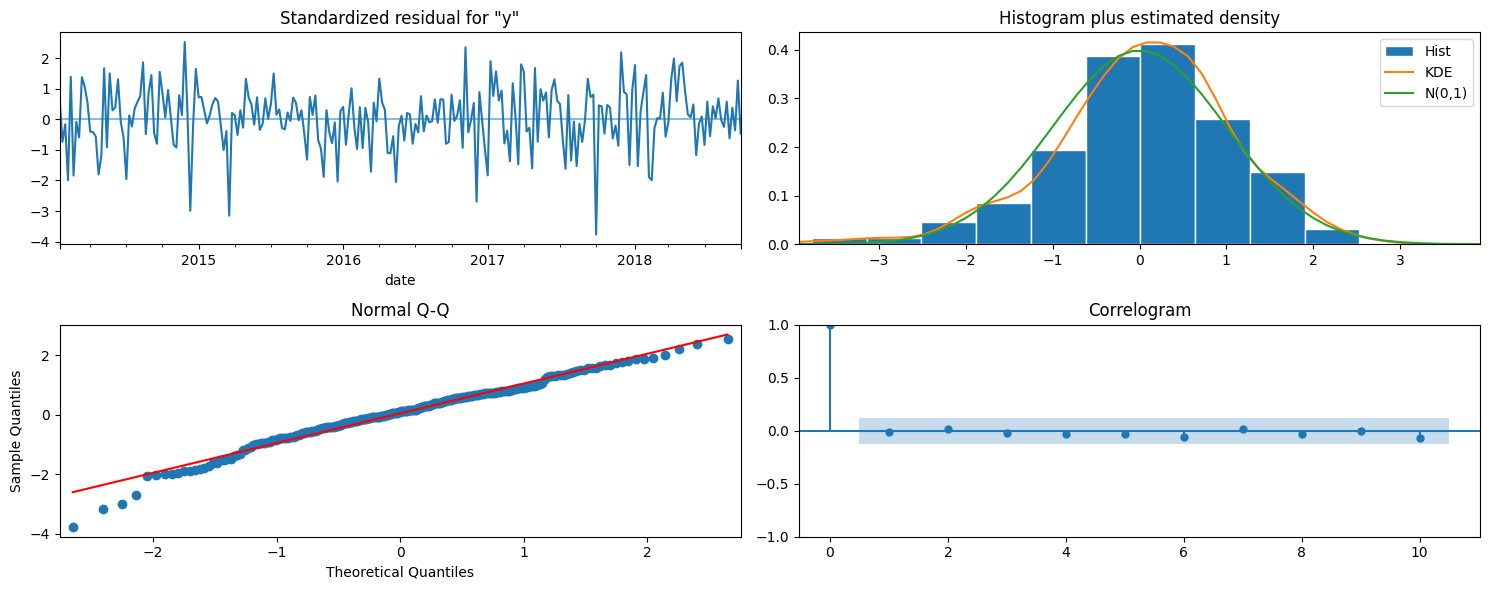

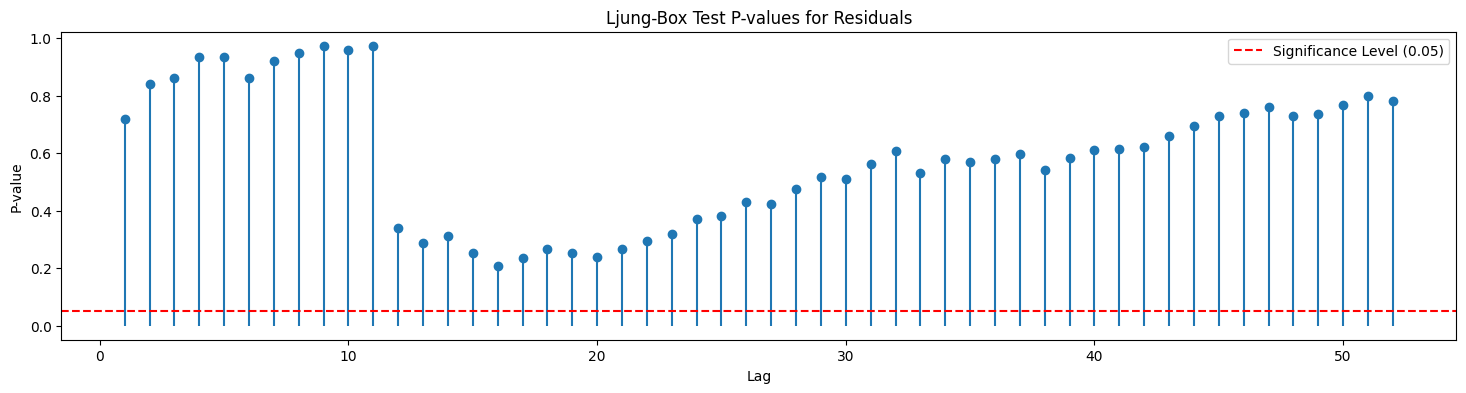

In [450]:
plot_arima_diagnostics_and_ljungbox(residual_model_fit, residual_ljung_box)

### **6.4. Choosing the best model** 

In [451]:
model_results = pd.DataFrame(columns=["Parameters statistically significant", "Residuals uncorrelated", "AIC", "BIC"])

model_results.loc["AR2"] = [True, False, ar2_model_fit.aic, ar2_model_fit.bic]
model_results.loc["AR3"] = [True, True, ar3_model_fit.aic, ar3_model_fit.bic]
model_results.loc["SARIMA(0, 1, 1)(1, 1, 1)[52]"] = [True, True, sarima_p0_model_fit.aic, sarima_p0_model_fit.bic]
model_results.loc["SARIMA(1, 1, 1)(1, 1, 1)[52]"] = [True, True, sarima_model_fit.aic, sarima_model_fit.bic]

model_results

,Parameters statistically significant,Residuals uncorrelated,AIC,BIC
AR2,True,False,244.949567,255.489853
AR3,True,True,234.389056,248.442771
"SARIMA(0, 1, 1)(1, 1, 1)[52]",True,True,218.126627,231.218625
"SARIMA(1, 1, 1)(1, 1, 1)[52]",True,True,217.265819,233.630816


While several models could be chosen for forecasting, we will select the one with the lowest AIC value, which is the **SARIMA(1, 1, 1)(1, 1, 1)[\52] model.**

---

## **7. Forecasting strategies**

### **7.1. Forecasting 52 weeks ahead**

To forecast 52 steps ahead, we will use unique training data, which implies using a unique model fit.

In [452]:
def forecast(model, test):
    model_fit = model.fit()
    
    predictions = model_fit.forecast(len(test))
    predictions = pd.Series(predictions, index=test.index)
    
    residuals = test - predictions
    return predictions, residuals

predictions, residuals = forecast(sarima_model, test)

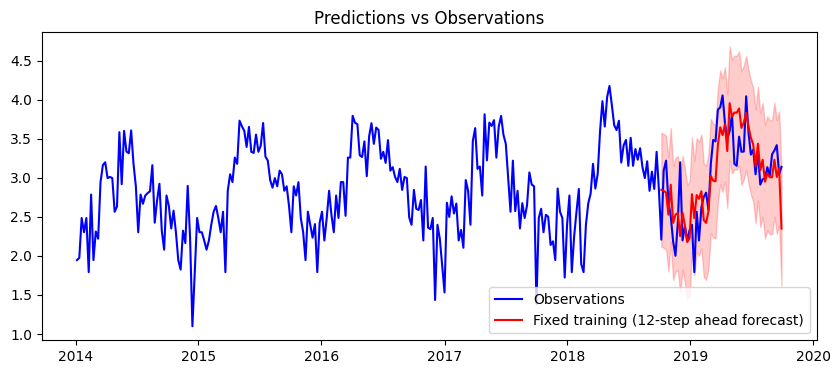

In [453]:
def plot_predictions(time_series, predictions, residuals, label):
    plt.figure(figsize=(10, 4))
    plt.plot(time_series, label='Observations', color='blue')
    plt.plot(predictions, label=label, color='red')
    plt.legend(loc='lower right')
    plt.title('Predictions vs Observations')
    plt.fill_between(predictions.index, predictions - 1.96*residuals.std(), predictions + 1.96*residuals.std(), color='red', alpha=0.2)
    plt.show()
    
plot_predictions(R06_log, predictions, residuals, 'Fixed training (12-step ahead forecast)')

### **7.2. Forecasting 52 weeks with 1-step ahead - Interaction**

- This forecasting strategy assumes we know the new data at the moment of the forecast, and we will not fit a new model based on new data.

- The forecast generation uses the fitted model to interact with new data to produce a forecast.

In [ ]:
def forecast_rolling_predictions(order, seasonal_order, test, full_dataset=R06_log):
    predictions = test.copy()

    for train_end in test.index:
        train_data = full_dataset[:train_end-timedelta(days=1)]

        model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit()

        last_fitted_value = model_fit.fittedvalues.iloc[-1]
        
        predictions[train_end] = last_fitted_value
        
    residuals = test - predictions
    return predictions, residuals

rolling_predictions, rolling_residuals = forecast_rolling_predictions((1,1,1), (1,1,1,52), test)

In [ ]:
plot_predictions(R06_log, rolling_predictions, rolling_residuals, 'Fixed training (1-step ahead forecast)')

### **7.3. Forecasting 52 weeks with 1-step ahead - Expanding windows**

- In the expanding window strategy, the training sample size increases sequentially by a time unit.

- The forecasts produced are based on multiple fit models.

In [ ]:
def forecast_expanding_windows(order, seasonal_order, test, full_dataset=R06_log):
    predictions = test.copy()

    for train_end in test.index:
        train_data = full_dataset[:train_end-timedelta(days=1)]

        model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit()

        pred = model_fit.forecast()
        predictions[train_end] = pred
        
    residuals = test - predictions
    return predictions, residuals

expanding_predictions, expanding_residuals = forecast_expanding_windows((1,1,1), (1,1,1,52), test)

In [ ]:
plot_predictions(R06_log, expanding_predictions, expanding_residuals, 'Expanding training (1-step ahead forecast)')

### **7.4. Forecasting 52 weeks with 1-step ahead - Recursive windows**

- In the recursive window strategy, the training sample maintains its size across the forecasting generation.

- However, with distinct sets of observation.

- The training sample window slides a time unit to produce a forecast.

- The forecasts produced are based on multiple fit models.

In [124]:
def forecast_recursive_windows(order, seasonal_order, test, full_dataset=R06_log):
    predictions = test.copy()
    train_starting_week = train.index[0]

    for i, train_end in enumerate(test.index):    
        train_data = full_dataset[train_starting_week+timedelta(days=7*i):train_end-timedelta(days=1)]
        
        model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit()

        pred = model_fit.forecast()
        predictions[train_end] = pred
        
    residuals = test - predictions
    return predictions, residuals

recursive_predictions, recursive_residuals = forecast_recursive_windows((1,1,1), (1,1,1,52), test)

In [ ]:
plot_predictions(R06_log, recursive_predictions, recursive_residuals, 'Recursive training (1-step ahead forecast)')

### **7.5. Decomposition Forecasting**

Below, we will explore the same forecasting strategies, but applied specifically to the residuals. The predicted values will be the result of combining the forecasts from the different models applied to the individual components (trend, seasonality, and residuals).

#### **Decomposition Forecasting 52 weeks ahead**

In [126]:
# fit seasonal and trend components 
x_test = np.arange(0, len(stl_train_result.trend) + len(test))

full_seasonal_fit = fourier_series(x_test, *params)
full_trend_fit = trend_model.predict(x_test.reshape(-1, 1))

# transform seasonal and trend components into pandas series
full_seasonal_fit = pd.Series(full_seasonal_fit, index=R06_log.index)
full_trend_fit = pd.Series(full_trend_fit, index=R06_log.index)

# get full data residuals by subtracting the trend and seasonal components from the full data using the models we just created
full_resid = R06_log - full_trend_fit - full_seasonal_fit

# transform full_resid into a pandas series
full_resid = pd.Series(full_resid, index=R06_log.index)

test_residual = full_resid[-52:]

In [127]:
rm_predictions, _ = forecast(residual_model, test_residual)

x_test = np.arange(len(stl_train_result.trend), len(stl_train_result.trend) + len(test))

pred_seasonal_fit = fourier_series(x_test, *params)
pred_trend_fit = trend_model.predict(x_test.reshape(-1, 1))

pred_seasonal_fit = pd.Series(pred_seasonal_fit, index=test.index)
pred_trend_fit = pd.Series(pred_trend_fit, index=test.index)

decomp_52_step_predictions = rm_predictions + pred_seasonal_fit + pred_trend_fit

decomp_52_step_predictions_original = np.exp(decomp_52_step_predictions)

residuals_decomp_52_step = test_original - decomp_52_step_predictions_original

In [ ]:
def plot_decomp_predictions(original_time_series, full_residual_time_series, predictions_original, residuals_original, rm_predictions):
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # Original time series
    axes[0].plot(original_time_series, label='Original', color='blue')
    axes[0].plot(predictions_original, label='Predicted', color='red')
    axes[0].fill_between(predictions_original.index, predictions_original - 1.96*residuals_original.std(), predictions_original + 1.96*residuals_original.std(), color='red', alpha=0.2)
    axes[0].set_title("Original Time Series")
    axes[0].legend()

    # Residual component
    axes[1].plot(full_residual_time_series, label='Model Residual', color='navy')
    axes[1].plot(rm_predictions, label='Predicted Residual', color='red')
    axes[1].set_title("Residual Component")
    axes[1].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_decomp_predictions(R06, full_resid, decomp_52_step_predictions_original, residuals_decomp_52_step, rm_predictions)

#### **Decomposition Forecasting 52 weeks with 1-step ahead - Interaction**

In [129]:
rm_rolling_predictions, _ = forecast_rolling_predictions((1,2,1), (0,0,0,0), test_residual, full_resid)

decomp_rolling_predictions = rm_rolling_predictions + pred_seasonal_fit + pred_trend_fit

decomp_rolling_predictions_original = np.exp(decomp_rolling_predictions)

residuals_decomp_rolling = test_original - decomp_rolling_predictions_original

In [ ]:
plot_decomp_predictions(R06, full_resid, decomp_rolling_predictions_original, residuals_decomp_rolling, rm_rolling_predictions)

#### **Decomposition Forecasting 52 weeks with 1-step ahead - Expanding Windows**

In [131]:
rm_exp_windows_predictions, _ = forecast_expanding_windows((1,2,1), (0,0,0,0), test_residual, full_resid)

decomp_exp_windows_predictions = rm_exp_windows_predictions + pred_seasonal_fit + pred_trend_fit

decomp_exp_windows_predictions_original = np.exp(decomp_exp_windows_predictions)

residuals_decomp_exp_windows = test_original - decomp_exp_windows_predictions_original

In [ ]:
plot_decomp_predictions(R06, full_resid, decomp_exp_windows_predictions_original, residuals_decomp_exp_windows, rm_exp_windows_predictions)

#### **Decomposition Forecasting 52 weeks with 1-step ahead - Recursive Windows**

In [133]:
rm_rec_windows_predictions, _ = forecast_recursive_windows((1,2,1), (0,0,0,0), test_residual, full_resid)

decomp_rec_windows_predictions = rm_rec_windows_predictions + pred_seasonal_fit + pred_trend_fit

decomp_rec_windows_predictions_original = np.exp(decomp_rec_windows_predictions)

residuals_decomp_rec_windows = test_original - decomp_rec_windows_predictions_original

In [ ]:
plot_decomp_predictions(R06, full_resid, decomp_rec_windows_predictions_original, residuals_decomp_rec_windows, rm_rec_windows_predictions)

---

## **8. Assessing the quality of produced forecasts**

### **8.1. Plotting the forecasts**

In [ ]:
plt.figure(figsize=(15,7))

plt.plot(test_original)
plt.plot(np.exp(predictions))
plt.plot(np.exp(rolling_predictions))
plt.plot(np.exp(expanding_predictions))
plt.plot(np.exp(recursive_predictions))

plt.legend(('Observations','52-Step Prediction', '1-Step Interaction', '1-Step Expanding Windows', '1-Step Recursive Windows'), fontsize=16)

plt.title('Weekly R06 Sales - SARIMA', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Year', fontsize=16)

plt.show()

In [ ]:
plt.figure(figsize=(15,7))

plt.plot(test_original)
plt.plot(decomp_52_step_predictions_original)
plt.plot(decomp_rolling_predictions_original)
plt.plot(decomp_exp_windows_predictions_original)
plt.plot(decomp_rec_windows_predictions_original)

plt.legend(('Observations','52-Step Prediction', '1-Step Interaction', '1-Step Expanding Windows', '1-Step Recursive Windows'), fontsize=16)

plt.title('Weekly R06 Sales - Decomposition', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Year', fontsize=16)

### **8.2. Plotting the forecast residuals**

In [ ]:
def get_orginal_residuals(original_data, predictions):
    original_residuals = original_data - np.exp(predictions)
    return original_residuals

plt.figure(figsize=(15,7))

plt.plot(get_orginal_residuals(test_original, predictions))
plt.plot(get_orginal_residuals(test_original, rolling_predictions))
plt.plot(get_orginal_residuals(test_original, expanding_predictions))
plt.plot(get_orginal_residuals(test_original, recursive_predictions))

plt.legend(('52-Step Prediction', '1-Step Interaction', '1-Step Expanding Windows', '1-Step Recursive Windows'), fontsize=16)

plt.axhline(y=0, color='black', linestyle='--')
plt.title('Weekly R06 Sales Residuals - SARIMA', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Year', fontsize=16)

In [ ]:
plt.figure(figsize=(15,7))

plt.plot(residuals_decomp_52_step)
plt.plot(residuals_decomp_rolling)
plt.plot(residuals_decomp_exp_windows)
plt.plot(residuals_decomp_rec_windows)

plt.legend(('52-Step Prediction', '1-Step Interaction', '1-Step Expanding Windows', '1-Step Recursive Windows'), fontsize=16)

plt.axhline(y=0, color='black', linestyle='--')
plt.title('Weekly R06 Sales Residuals - Decomposition', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Year', fontsize=16)

### **8.3. Accurary measures**

In [ ]:
models = {
    'SARIMA 52-Step Prediction': get_orginal_residuals(test_original, predictions),
    'SARIMA 1-Step Interaction': get_orginal_residuals(test_original, rolling_predictions),
    'SARIMA 1-Step Expanding Windows': get_orginal_residuals(test_original, expanding_predictions),
    'SARIMA 1-Step Recursive Windows': get_orginal_residuals(test_original, recursive_predictions),
    'Decomposition 52-Step Prediction': residuals_decomp_52_step,
    'Decomposition 1-Step Interaction': residuals_decomp_rolling,
    'Decomposition 1-Step Expanding Windows': residuals_decomp_exp_windows,
    'Decomposition 1-Step Recursive Windows': residuals_decomp_rec_windows
}

In [ ]:
errors = pd.DataFrame({
    'ME': [np.mean(residuals) for residuals in models.values()],
    'RMSE': [np.sqrt(np.mean(residuals**2)) for residuals in models.values()],
    'MAE': [np.mean(abs(residuals)) for residuals in models.values()],
    'MPE': [np.mean(residuals / test_original) * 100 for residuals in models.values()],
    'MAPE': [np.mean(abs(residuals / test_original)) * 100 for residuals in models.values()],
    'ACF1': [pd.Series(residuals).autocorr(lag=1) for residuals in models.values()]
}, index=models.keys())

errors

Overall, the forecating strategy that generated more accurate forecasts was the **expanding training windows.**

## **Conclusions**

To conclude, the **SARIMA(1,1,1)(1,1,1)[\52]** model is the most accurate but also the most computationally expensive. It requires seasonal differencing (D=1), which leads to the loss of 1 year of data. Additionally, the confidence intervals are quite wide, indicating some uncertainty in the longer-term forecasts.

On the other hand, the combination of a **Linear Model for Trend, Fourier Series for Seasonality, and ARIMA(1,2,2) on Residuals** achieves similar results for rolling (1-step) predictions, while being much less computationally expensive. While it is less accurate for 52-step predictions compared to the SARIMA model, it still performs better than using the ARIMA model alone, offering a more efficient alternative with relatively good forecasting performance.

Overall, the best forecasting strategy was the **expanding windows** approach, which provided the most reliable results.

## **Bibliography**

- Zdravkovic, M. (2025). Pharma Sales Data. Kaggle. https://www.kaggle.com/datasets/milanzdravkovic/pharma-sales-data 

- Cotta, P. V. (2020). Introdução ao ARIMA e SARIMA: Modelos de Séries Temporais. Medium. https://medium.com/@paulovpcotta introdu%C3%A7%C3%A3o-ao-arima-e-sarima-modelos-de-s%C3%A9ries-temporais-51992ae5abfd 

- Tankard, J. C. (2020). Forecasting with Fourier Series. Medium. https://medium.com/@jcatankard_76170/forecasting-with-fourier-series-8196721e7a3a 

- Hyndman, R. J., & Athanasopoulos, G. (2020). STL Decomposition. In Forecasting: Principles and Practice (2nd ed.). OTexts. https://otexts.com/fpp2/stl.html

- Moodle Course Info. (2025). Moodle Course. https://moodle2425.up.pt/course/view.php?id=6699 